In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)
import mxnet as mx
import numpy as np

fname = mx.test_utils.download('http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data')
data = np.genfromtxt(fname, delimiter=',')
data

INFO:root:letter-recognition.data exists, skipping download


array([[nan,  2.,  8., ...,  8.,  0.,  8.],
       [nan,  5., 12., ...,  8.,  4., 10.],
       [nan,  4., 11., ...,  7.,  3.,  9.],
       ...,
       [nan,  6.,  9., ..., 12.,  2.,  4.],
       [nan,  2.,  3., ...,  9.,  5.,  8.],
       [nan,  4.,  9., ...,  7.,  2.,  8.]])

In [9]:
!head letter-recognition.data

T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7
B,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10
A,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7
J,2,2,4,4,2,10,6,2,6,12,4,8,1,6,1,7
M,11,15,13,9,7,13,2,6,2,12,1,9,8,1,1,8


In [17]:
data = np.genfromtxt(fname=fname, delimiter=',')[:,1:]
label = np.array([ord(l.split(',')[0]) - ord('A') for l in open(fname, 'r')])

In [21]:
batch_size = 32
nrof_train = int(data.shape[0] * 0.8)
train_iter = mx.io.NDArrayIter(data[:nrof_train, :], 
                               label[:nrof_train], 
                               batch_size,
                               shuffle=True)
val_iter = mx.io.NDArrayIter(data[nrof_train:, :],
                            label[nrof_train:],
                            batch_size,
                            shuffle=True)

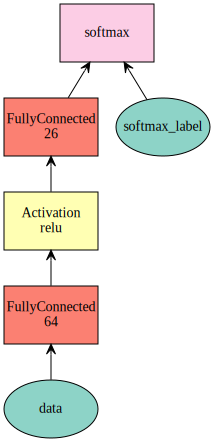

In [23]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(net, name='softmax')
mx.viz.plot_network(net)

In [25]:
mod = mx.mod.Module(symbol=net,
                   context=mx.cpu(),
                   data_names=['data'],
                   label_names=['softmax_label'])

In [31]:
mx.mod.Module?

In [32]:
mx.init.Uniform?

In [36]:
# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1),))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  after removing the cwd from sys.path.


Epoch 0, Training ('accuracy', 0.818625)
Epoch 1, Training ('accuracy', 0.8321875)
Epoch 2, Training ('accuracy', 0.8319375)
Epoch 3, Training ('accuracy', 0.836625)
Epoch 4, Training ('accuracy', 0.841375)


## High level interface

Some of the other metrics which can be used are `top_k_acc`(top-k-accuracy),
`F1`, `RMSE`, `MSE`, `MAE`, `ce`(CrossEntropy). To learn more about the metrics,
visit [Evaluation metric](http://mxnet.io/api/python/metric.html).

One can vary number of epochs, learning_rate, optimizer parameters to change the score
and tune these parameters to get best score.

In [68]:
train_iter.reset()

mod = mx.mod.Module(symbol=net,
                   context=mx.cpu(),
                   data_names=['data'],
                   label_names=['softmax_label'])
model_prefix = '/tmp/mx_mlp'
checkpoint = mx.callback.do_checkpoint(model_prefix, period=1)

# fit the module
mod.fit(train_iter,
       eval_data = val_iter,
       optimizer='sgd',
       optimizer_params={'learning_rate': 0.1},
       eval_metric='acc',
       num_epoch=10,
       epoch_end_callback=checkpoint)

INFO:root:Epoch[0] Train-accuracy=0.375875
INFO:root:Epoch[0] Time cost=2.956
INFO:root:Saved checkpoint to "/tmp/mx_mlp-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.609000
INFO:root:Epoch[1] Train-accuracy=0.620687
INFO:root:Epoch[1] Time cost=2.763
INFO:root:Saved checkpoint to "/tmp/mx_mlp-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.655000
INFO:root:Epoch[2] Train-accuracy=0.691875
INFO:root:Epoch[2] Time cost=2.241
INFO:root:Saved checkpoint to "/tmp/mx_mlp-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.668750
INFO:root:Epoch[3] Train-accuracy=0.730688
INFO:root:Epoch[3] Time cost=3.365
INFO:root:Saved checkpoint to "/tmp/mx_mlp-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.750000
INFO:root:Epoch[4] Train-accuracy=0.755062
INFO:root:Epoch[4] Time cost=2.855
INFO:root:Saved checkpoint to "/tmp/mx_mlp-0005.params"
INFO:root:Epoch[4] Validation-accuracy=0.769500
INFO:root:Epoch[5] Train-accuracy=0.767375
INFO:root:Epoch[5] Time cost=2.633
INFO:root:Sa

In [43]:
y = mod.predict(val_iter)
assert y.shape == (4000, 26)
y[0]


[6.9424822e-12 1.8080443e-24 2.4983731e-18 8.5404173e-10 7.8334304e-19
 2.9712787e-23 2.8113226e-18 9.9879104e-01 1.3127037e-18 6.9116050e-12
 3.0078885e-14 3.6359439e-18 7.2545481e-10 1.4594660e-07 1.2083856e-03
 5.3696913e-15 4.7579280e-07 7.0764466e-14 2.1306461e-19 1.8026060e-29
 7.4120079e-14 2.4006099e-18 1.4855658e-18 2.9375045e-14 5.0452612e-23
 6.1624591e-25]
<NDArray 26 @cpu(0)>

In [42]:
mod.predict?

In [53]:
score = mod.score(val_iter, ['acc'])
print('Accuracy score is %f' % (score[0][1]))
score

Accuracy score is 0.774250


[('accuracy', 0.77425)]

In [55]:
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, epoch=3)
assert sym.tojson() == net.tojson()

In [65]:
mod = mx.mod.Module(symbol=sym)
mod.set_params(arg_params, aux_params)
score = mod.score(val_iter, ['acc'])
score

AssertionError: call bind before initializing the parameters

In [82]:
mod = mx.mod.Module(symbol=net)
mod.fit(train_iter,
       num_epoch=8,
       arg_params=arg_params,
       aux_params=aux_params,
       begin_epoch=11)
print('train done')

train done


In [83]:
mod.fit?